## Evaluate Multiple Classifiers

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display, HTML
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, load_from_disk, concatenate_datasets
from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
import numpy as np
import torch
import os

/home/jschelb/.pyenv/versions/3.10.8/envs/s2j-content-analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Random Seed for Reproducibility

In [2]:
# Set a seed for random module
random.seed(42)

# Set a seed for numpy module
np.random.seed(42)

# Set a seed for torch module
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define Parameters

In [3]:
SAMPLING = "random" # "random", "stratified", "clustered", "shared_domain"
SUFFIX = "_extended" #"", "_holdout", "_extended"
SPLITS = ["test", "holdout", "extended"] # "train", "test", "holdout", "extended"
MAX_CONTENT_LENGTH = 384 # 496, 192
OVERLAP = 64
FEATURES = "url_and_content" # "url", "content", "url_and_content"

In [4]:
TOPICS = ["cannabis", "kinder", "energie"]
#TOPICS = ["cannabis"]

In [5]:
MODEL = "deepset/gelectra-large"

## Helpers

In [6]:
def calc_metrics(labels, preds):
    """
    Calculates the accuracy, precision, recall, and F1 score for the given labels and predictions and returns them in a dictionary.
    """
    
    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1': f1_score(labels, preds, average='binary'),
    }

    return metrics

In [7]:
def sample_random_from_dataset(dataset, n=5, subset='test'):
    """
    Samples n random examples from a specified subset of the dataset.
    """
    n = min(n, len(dataset[subset]))
    random_indices = random.sample(range(len(dataset[subset])), n)
    sampled_dataset = dataset[subset].select(random_indices)
    return sampled_dataset

## Page Level Predictions

In [8]:
from collections import Counter
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [9]:
from datasets import DatasetDict, concatenate_datasets, load_from_disk

def load_and_merge_datasets(topic, model_name, sampling, suffix, max_content_length, features, splits):
    """Loads specified splits from disk and merges them into a single dataset. """
    datasets_to_merge = []
    
    for split in splits:
        path = f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_{sampling}{suffix}_{max_content_length}_s_{model_name.split('/')[1]}_{features}_{split}"
        try:
            dataset = load_from_disk(path)
            if split in dataset:
                datasets_to_merge.append(dataset[split])
            else:
                print(f"Warning: Split '{split}' not found in the loaded dataset from {path}.")
        except Exception as e:
            print(f"Error loading split '{split}' from path '{path}': {e}")
    
    if datasets_to_merge:
        merged_dataset = concatenate_datasets(datasets_to_merge)
        return merged_dataset
    else:
        print("No valid splits provided for merging.")
        return None

def load_dataset(topic, model_name, sampling, suffix, max_content_length, features, split):
    path = f"../../data/tmp/processed_dataset_{topic}_buffed_chunkified_{sampling}{suffix}_{max_content_length}_s_{model_name.split('/')[1]}_{features}_{split}"
    return load_from_disk(path)

def merge_dataset_splits(dataset_dict, splits):
    """Merges specified splits from a DatasetDict into a single dataset."""
    datasets_to_merge = []
    
    for split in splits:
        if split in dataset_dict:
            datasets_to_merge.append(dataset_dict[split])
        else:
            print(f"Warning: Split '{split}' not found in dataset_dict.")
    
    if datasets_to_merge:
        merged_dataset = concatenate_datasets(datasets_to_merge)
        return merged_dataset
    else:
        print("No valid splits provided for merging.")
        return None


def group_dataset_by_url(dataset):
    grouped_dataset = {}
    for example in tqdm(dataset, desc="Grouping dataset by URL"):
        url = example.get("view_url") or example.get("domain")
        example_filtered = {k: example[k] for k in ["text", "domain", "preds", "label", "category", "annotation_type", "lang", "probas"]}
        grouped_dataset.setdefault(url, []).append(example_filtered)
    return grouped_dataset

def extract_labels(grouped_dataset):
    labels = []
    for chunks in grouped_dataset.values():
        preds = [chunk["label"] for chunk in chunks]
        labels.append(max(preds))
    return labels

def merge_predictions(grouped_dataset):
    predictions = []
    for chunks in grouped_dataset.values():
        preds = [chunk["preds"] for chunk in chunks]
        predictions.append(max(preds))
    return predictions

def merge_probabilities(grouped_dataset):
    probas = []
    for chunks in grouped_dataset.values():
        probas.append(max(chunk["probas"] for chunk in chunks))
    return probas

def plot_precision_recall_curve(recall, precision, pr_auc, model_name, topic, splits):
    plt.figure()
    plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'P-R Curve {model_name} - {topic}')
    plt.legend(loc='best')

    filename = f'precision_recall_curve_{model_name.split("/")[1]}_{topic}_{"_".join(splits)}.png'.replace(' ', '_')
    plt.savefig(filename, dpi=300)
    plt.show()

**PR-Curves per Model:**

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Dictionary to store the processed data
data_dict = {}

# First loop: Load and process datasets
for topic in TOPICS:
    print(f"\n\n###### Loading and processing data for {topic} ###### \n\n")
    
    try:
        # Load and merge datasets
        dataset = load_and_merge_datasets(topic, MODEL, SAMPLING, SUFFIX, MAX_CONTENT_LENGTH, FEATURES, SPLITS)
        
        # Group dataset by URL
        grouped_dataset = group_dataset_by_url(dataset)
        
        # Extract labels and probabilities
        labels = extract_labels(grouped_dataset)
        probas = merge_probabilities(grouped_dataset)
        predictions = merge_predictions(grouped_dataset)
        
        # Store the results in the dictionary
        data_dict[topic] = (labels, probas, predictions,)
    
    except Exception as e:
        print(f"An error occurred while processing {MODEL} on {topic}: {e}")




###### Loading and processing data for cannabis ###### 




Grouping dataset by URL: 100%|██████████| 259453/259453 [00:41<00:00, 6242.46it/s]




###### Loading and processing data for kinder ###### 




Grouping dataset by URL: 100%|██████████| 300684/300684 [00:49<00:00, 6133.25it/s]




###### Loading and processing data for energie ###### 




Grouping dataset by URL: 100%|██████████| 270601/270601 [00:42<00:00, 6339.00it/s]


In [11]:
import numpy as np
from matplotlib import cm

Precision-Recall AUC for kinder: 0.87


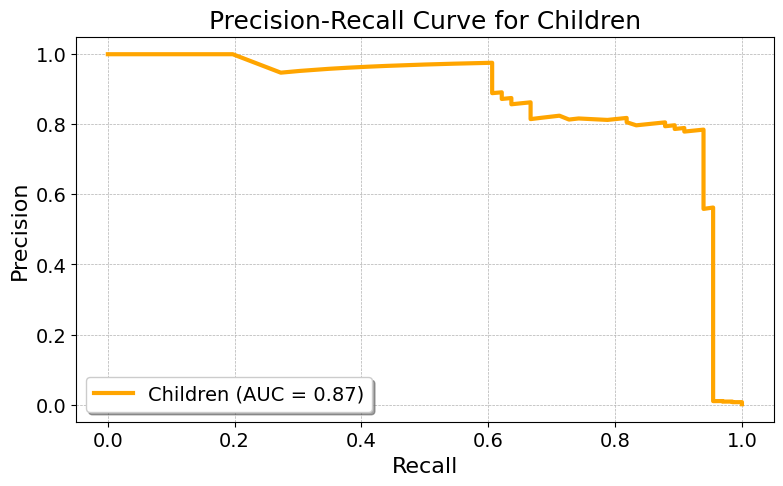

Precision-Recall AUC for energie: 0.66


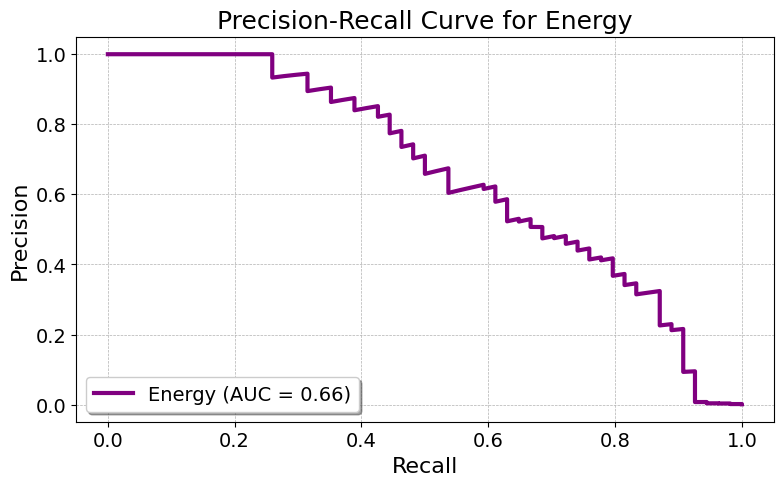

Precision-Recall AUC for cannabis: 0.93


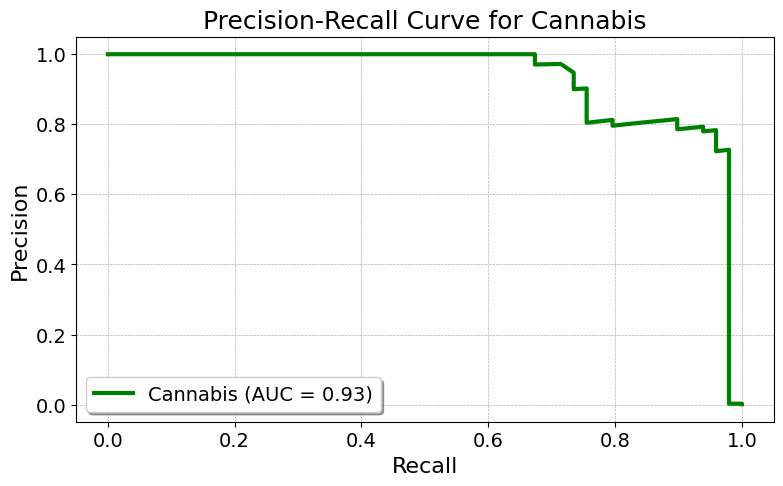

Precision-Recall AUC for Combined: 0.68


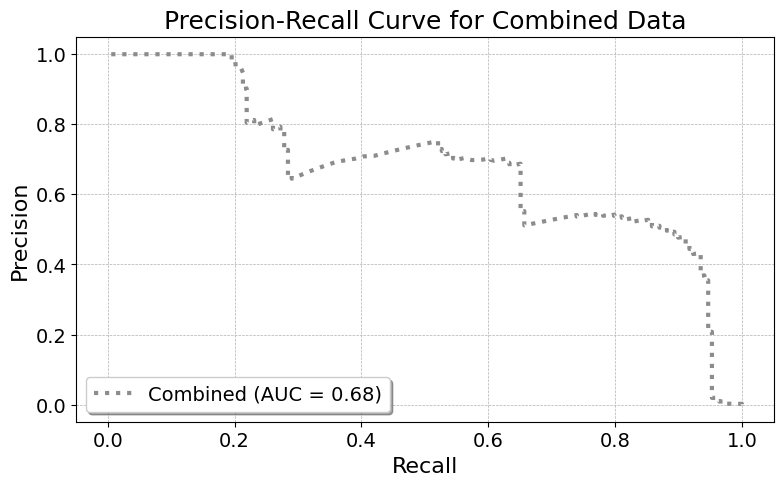

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd

# Mapping of topics to legend texts
legend_texts = {
    'kinder': 'Children',
    'energie': 'Energy',
    'cannabis': 'Cannabis'
}

# Desired order of topics for plotting
ordered_topics = ['kinder', 'energie', 'cannabis']

# Color mapping for topics
color_mapping = {
    'kinder': '#FFA500',   # Orange-Yellow
    'energie': '#800080',  # Purple
    'cannabis': '#008000', # Green
    'combined': '#8C8C8C'  # Grey
}

# Initialize lists to store combined labels and probabilities
combined_labels = []
combined_probas = []
combined_predictions = []

for topic in ordered_topics:
    if topic in data_dict:
        labels, probas, predictions = data_dict[topic]
        combined_labels.extend(labels)
        combined_probas.extend(probas)
        combined_predictions.extend(predictions)
        
        try:
            precision, recall, thresholds = precision_recall_curve(labels, probas)
            pr_auc = auc(recall, precision)
            print(f'Precision-Recall AUC for {topic}: {pr_auc:.2f}')

            # Plot the precision-recall curve for the current topic
            plt.figure(figsize=(9, 5))
            plt.plot(recall, precision, label=f'{legend_texts.get(topic, topic)} (AUC = {pr_auc:.2f})', color=color_mapping[topic], linewidth=3)
            plt.xlabel('Recall', fontsize=16)
            plt.ylabel('Precision', fontsize=16)
            plt.grid(True, linestyle='--', linewidth=0.5)
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.legend(loc='lower left', fontsize=14, frameon=True, shadow=True)
            plt.title(f'Precision-Recall Curve for {legend_texts.get(topic, topic)}', fontsize=18)
            plt.show()
        
        except Exception as e:
            print(f"An error occurred while plotting {topic}: {e}")

# Calculate and plot the PR curve for combined data
if combined_labels and combined_probas:
    precision, recall, thresholds = precision_recall_curve(combined_labels, combined_probas)
    pr_auc = auc(recall, precision)
    print(f'Precision-Recall AUC for Combined: {pr_auc:.2f}')
    
    plt.figure(figsize=(9, 5))
    plt.plot(recall, precision, label=f'Combined (AUC = {pr_auc:.2f})', color=color_mapping['combined'], linestyle='dotted', linewidth=3)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(loc='lower left', fontsize=14, frameon=True, shadow=True)
    plt.title('Precision-Recall Curve for Combined Data', fontsize=18)
    plt.show()


Precision-Recall AUC for kinder: 0.87
Precision-Recall AUC for energie: 0.66
Precision-Recall AUC for cannabis: 0.93
Precision-Recall AUC for Combined: 0.68


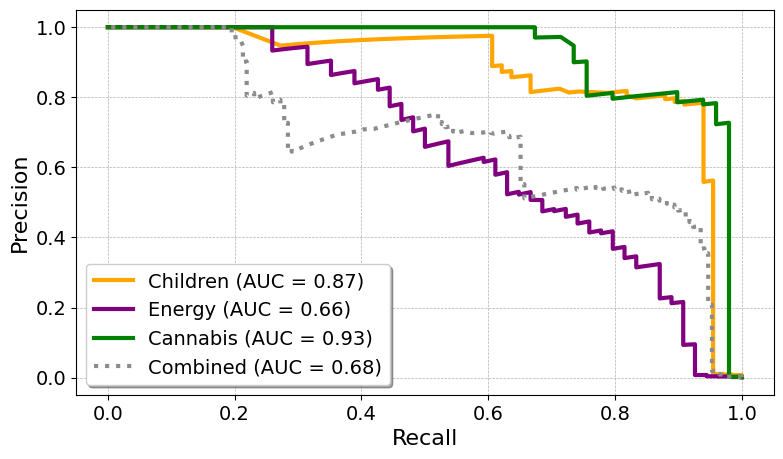

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd
from matplotlib import cm

# Mapping of topics to legend texts
legend_texts = {
    'kinder': 'Children',
    'energie': 'Energy',
    'cannabis': 'Cannabis'
}

# Desired order of topics for plotting
ordered_topics = ['kinder', 'energie', 'cannabis']

# Color mapping for topics
color_mapping = {
    'kinder': '#FFA500',   # Orange-Yellow
    'energie': '#800080',  # Purple
    'cannabis': '#008000', # Green
    'combined': '#8C8C8C'  # Grey
}

# Second loop: Create the figure
plt.figure(figsize=(9, 5)) 
#plt.title(f'Precision-Recall Curves for {MODEL.split("/")[1]}', fontsize=18)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Initialize lists to store combined labels and probabilities
combined_labels = []
combined_probas = []
combined_predictions = []

for topic in ordered_topics:
    if topic in data_dict:
        labels, probas, predictions = data_dict[topic]
        combined_labels.extend(labels)
        combined_probas.extend(probas)
        combined_predictions.extend(predictions)
        
        try:
            precision, recall, thresholds = precision_recall_curve(labels, probas)
            pr_auc = auc(recall, precision)
            print(f'Precision-Recall AUC for {topic}: {pr_auc:.2f}')

            # Plot the precision-recall curve for the current topic
            legend_text = legend_texts.get(topic, topic)  # Use the mapped text if available
            plt.plot(recall, precision, label=f'{legend_text} (AUC = {pr_auc:.2f})', color=color_mapping[topic], linewidth=3)
        
        except Exception as e:
            print(f"An error occurred while plotting {MODEL} on {topic}: {e}")

# Calculate and plot the PR curve for combined data
if combined_labels and combined_probas:
    precision, recall, thresholds = precision_recall_curve(combined_labels, combined_probas)
    pr_auc = auc(recall, precision)
    print(f'Precision-Recall AUC for Combined: {pr_auc:.2f}')
    plt.plot(recall, precision, label=f'Combined (AUC = {pr_auc:.2f})', color=color_mapping['combined'], linestyle='dotted', linewidth=3)

# Add legend and save the figure
plt.legend(loc='lower left', fontsize=14, frameon=True, shadow=True)
filename = f'precision_recall_curves_{MODEL.split("/")[1]}_{"_".join(SPLITS)}.pdf'.replace(' ', '_')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

# Mapping of topics to legend texts
legend_texts = {
    'kinder': 'Children',
    'energie': 'Energy',
    'cannabis': 'Cannabis'
}

# Desired order of topics for calculation
ordered_topics = ['kinder', 'energie', 'cannabis']

metrics = []

# Initialize lists to store combined labels and probabilities
combined_labels = []
combined_probas = []
combined_predictions = []

for topic in ordered_topics:
    if topic in data_dict:
        labels, probas, predictions = data_dict[topic]
        combined_labels.extend(labels)
        combined_probas.extend(probas)
        combined_predictions.extend(predictions)
        
        try:
            # Calculate additional metrics
            predictions = [1 if p >= 0.5 else 0 for p in probas]
            topic_precision = precision_score(labels, predictions)
            topic_recall = recall_score(labels, predictions)
            topic_accuracy = accuracy_score(labels, predictions)
            topic_f1 = f1_score(labels, predictions)
            positive_cases = sum(labels)
            negative_cases = len(labels) - positive_cases

            metrics.append({
                'Topic': legend_texts.get(topic, topic),
                'Precision': topic_precision,
                'Recall': topic_recall,
                'Accuracy': topic_accuracy,
                'F1 Score': topic_f1,
                'Positive Cases': positive_cases,
                'Negative Cases': negative_cases
            })
        
        except Exception as e:
            print(f"An error occurred while processing {topic}: {e}")

# Display metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

      Topic  Precision    Recall  Accuracy  F1 Score  Positive Cases  \
0  Children   0.420000  0.954545  0.998407  0.583333              66   
1    Energy   0.082237  0.925926  0.988790  0.151057              54   
2  Cannabis   0.387097  0.979592  0.998388  0.554913              49   

   Negative Cases  
0           56418  
1           50081  
2           47704  


Precision-Recall AUC for kinder: 0.87
Precision-Recall AUC for energie: 0.66
Precision-Recall AUC for cannabis: 0.93
Precision-Recall AUC for Combined: 0.68


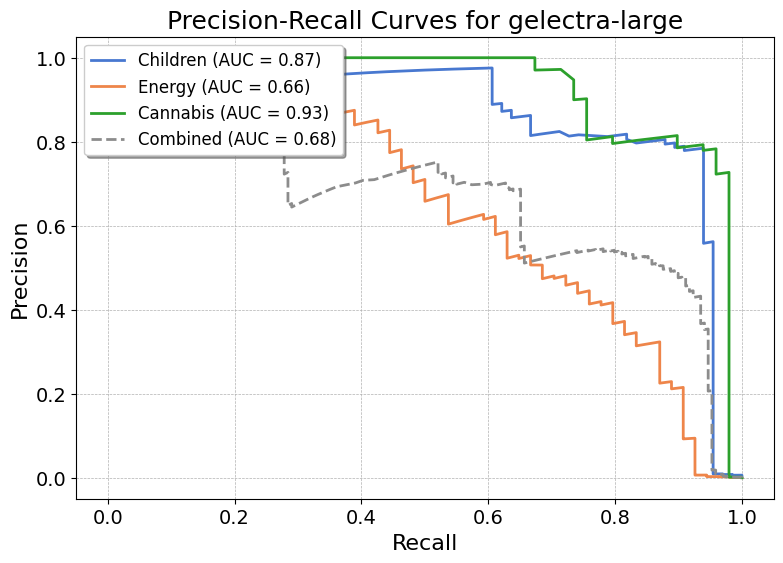

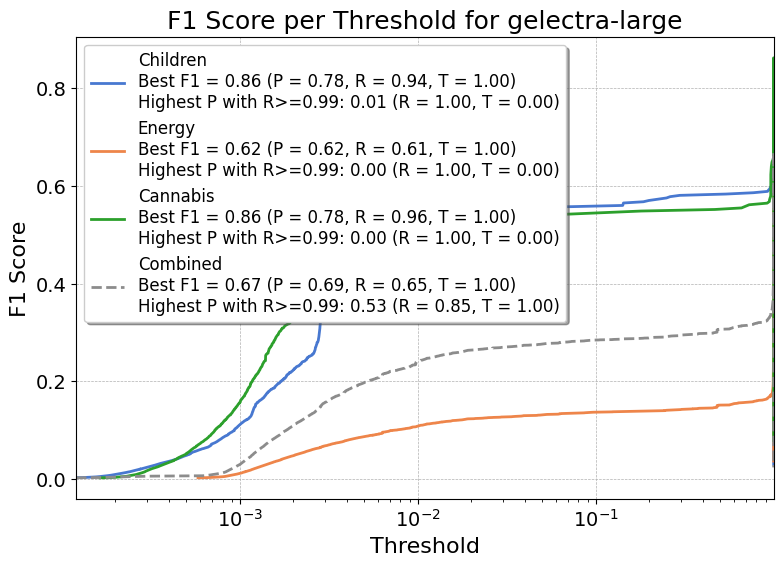

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
import numpy as np
import pandas as pd
from matplotlib import cm

# Mapping of topics to legend texts
legend_texts = {
    'kinder': 'Children',
    'energie': 'Energy',
    'cannabis': 'Cannabis'
}

# Desired order of topics for plotting
ordered_topics = ['kinder', 'energie', 'cannabis']

# Color mapping for topics
color_mapping = {
    'kinder': '#4878D0',   # Blue
    'energie': '#EE854A',  # Orange
    'cannabis': '#2CA02C', # Dark Red
    'combined': '#8C8C8C'  # Grey
}

# Create the first figure for Precision-Recall curves
fig1, ax1 = plt.subplots(figsize=(9, 6)) 
ax1.set_title(f'Precision-Recall Curves for {MODEL.split("/")[1]}', fontsize=18)
ax1.set_xlabel('Recall', fontsize=16)
ax1.set_ylabel('Precision', fontsize=16)
ax1.grid(True, linestyle='--', linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Initialize lists to store combined labels and probabilities
combined_labels = []
combined_probas = []

# Create the second figure for F1 score per threshold
fig2, ax2 = plt.subplots(figsize=(9, 6)) 
ax2.set_title(f'F1 Score per Threshold for {MODEL.split("/")[1]}', fontsize=18)
ax2.set_xlabel('Threshold', fontsize=16)
ax2.set_ylabel('F1 Score', fontsize=16)
ax2.grid(True, linestyle='--', linewidth=0.5)
ax2.tick_params(axis='both', which='major', labelsize=14)

for topic in ordered_topics:
    if topic in data_dict:
        labels, probas = data_dict[topic]
        combined_labels.extend(labels)
        combined_probas.extend(probas)
        try:
            precision, recall, thresholds = precision_recall_curve(labels, probas)
            pr_auc = auc(recall, precision)
            print(f'Precision-Recall AUC for {topic}: {pr_auc:.2f}')

            # Calculate F1 score for each threshold
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            # Find the best F1 score and its corresponding precision, recall, and threshold
            best_idx = np.argmax(f1_scores)
            best_f1 = f1_scores[best_idx]
            best_precision = precision[best_idx]
            best_recall = recall[best_idx]
            best_threshold = thresholds[best_idx]

            # Find the threshold with at least 99% recall but highest precision
            high_recall_idx = np.where(recall >= 0.99)[0]
            if len(high_recall_idx) > 0:
                highest_precision_idx = high_recall_idx[np.argmax(precision[high_recall_idx])]
                highest_precision = precision[highest_precision_idx]
                highest_precision_threshold = thresholds[highest_precision_idx]
                highest_recall = recall[highest_precision_idx]
            else:
                highest_precision = 0
                highest_precision_threshold = 0
                highest_recall = 0
            
            # Plot the precision-recall curve for the current topic
            legend_text = legend_texts.get(topic, topic)  # Use the mapped text if available
            ax1.plot(recall, precision, label=f'{legend_text} (AUC = {pr_auc:.2f})', color=color_mapping[topic], linewidth=2)

            # Plot F1 score for each threshold
            ax2.plot(thresholds, f1_scores[:-1], label=f'{legend_text}\nBest F1 = {best_f1:.2f} (P = {best_precision:.2f}, R = {best_recall:.2f}, T = {best_threshold:.2f})\nHighest P with R>=0.99: {highest_precision:.2f} (R = {highest_recall:.2f}, T = {highest_precision_threshold:.2f})', color=color_mapping[topic], linewidth=2)

        except Exception as e:
            print(f"An error occurred while plotting {MODEL} on {topic}: {e}")

# Calculate and plot the PR curve for combined data
if combined_labels and combined_probas:
    precision, recall, thresholds = precision_recall_curve(combined_labels, combined_probas)
    pr_auc = auc(recall, precision)
    print(f'Precision-Recall AUC for Combined: {pr_auc:.2f}')

    # Calculate F1 score for combined data
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Find the best F1 score and its corresponding precision, recall, and threshold
    best_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_idx]
    best_precision = precision[best_idx]
    best_recall = recall[best_idx]
    best_threshold = thresholds[best_idx]

    # Find the threshold with at least 99% recall but highest precision
    high_recall_idx = np.where(recall >= 0.85)[0]
    if len(high_recall_idx) > 0:
        highest_precision_idx = high_recall_idx[np.argmax(precision[high_recall_idx])]
        highest_precision = precision[highest_precision_idx]
        highest_precision_threshold = thresholds[highest_precision_idx]
        highest_recall = recall[highest_precision_idx]
    else:
        highest_precision = 0
        highest_precision_threshold = 0
        highest_recall = 0

    ax1.plot(recall, precision, label=f'Combined (AUC = {pr_auc:.2f})', color=color_mapping['combined'], linestyle='--', linewidth=2)

    # Plot F1 score for combined data
    ax2.plot(thresholds, f1_scores[:-1], label=f'Combined\nBest F1 = {best_f1:.2f} (P = {best_precision:.2f}, R = {best_recall:.2f}, T = {best_threshold:.2f})\nHighest P with R>=0.99: {highest_precision:.2f} (R = {highest_recall:.2f}, T = {highest_precision_threshold:.2f})', color=color_mapping['combined'], linestyle='--', linewidth=2)

# Add legends and save the figures
ax1.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
filename1 = f'precision_recall_curves_{MODEL.split("/")[1]}_{"_".join(SPLITS)}.pdf'.replace(' ', '_')
fig1.savefig(filename1, dpi=300, bbox_inches='tight')

# Adjust x-axis scaling for F1 score plot to logarithmic
ax2.set_xscale('log')
ax2.set_xlim([min(thresholds), max(thresholds)])  # Set the limit for x-axis

ax2.legend(loc='upper left', fontsize=12, frameon=True, shadow=True)
filename2 = f'f1_scores_per_threshold_{MODEL.split("/")[1]}_{"_".join(SPLITS)}.pdf'.replace(' ', '_')
fig2.savefig(filename2, dpi=300, bbox_inches='tight')

plt.show()


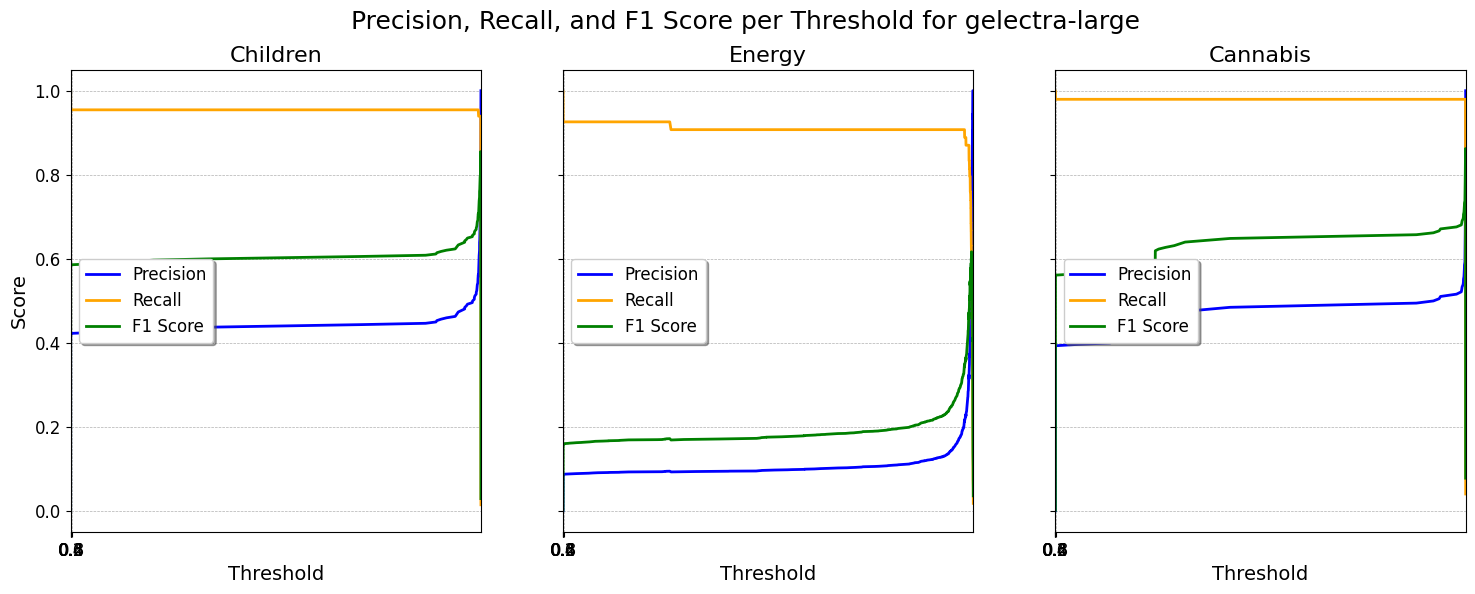

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import numpy as np
from matplotlib.ticker import LogLocator, FuncFormatter


def double_exponential_scale(x):
    return np.exp(np.exp(np.exp(x)))

def inverse_double_exponential_scale(x):
    return np.lognp.log(np.log(x))

# Mapping of topics to legend texts
legend_texts = {
    'kinder': 'Children',
    'energie': 'Energy',
    'cannabis': 'Cannabis'
}

# Desired order of topics for plotting
ordered_topics = ['kinder', 'energie', 'cannabis']

# Color mapping for topics
color_mapping = {
    'kinder': '#4878D0',   # Blue
    'energie': '#EE854A',  # Orange
    'cannabis': '#2CA02C'  # Green
}

# Formatter function for x-axis labels
def normal_format(x, pos):
    return f'{x:.2f}'

# Create subplots
fig, axs = plt.subplots(1, len(ordered_topics), figsize=(18, 6), sharey=True)
fig.suptitle(f'Precision, Recall, and F1 Score per Threshold for {MODEL.split("/")[1]}', fontsize=18)

for i, topic in enumerate(ordered_topics):
    if topic in data_dict:
        labels, probas = data_dict[topic]
        try:
            precision, recall, thresholds = precision_recall_curve(labels, probas)
            f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
            
            ax = axs[i]
            ax.set_title(legend_texts[topic], fontsize=16)
            ax.set_xlabel('Threshold', fontsize=14)
            if i == 0:
                ax.set_ylabel('Score', fontsize=14)
            ax.grid(True, linestyle='--', linewidth=0.5)
            ax.tick_params(axis='both', which='major', labelsize=12)
            ax.set_xscale('function', functions=(double_exponential_scale, inverse_double_exponential_scale))
            #ax.set_xscale('log')
            ax.set_xlim([min(thresholds), max(thresholds)])  # Set the limit for x-axis
            #ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
            #ax.xaxis.set_major_formatter(FuncFormatter(normal_format))
            
            
            # Plot Precision, Recall, and F1 score
            ax.plot(thresholds, precision[:-1], label='Precision', color='blue', linewidth=2)
            ax.plot(thresholds, recall[:-1], label='Recall', color='orange', linewidth=2)
            ax.plot(thresholds, f1_scores[:-1], label='F1 Score', color='green', linewidth=2)
            
            # Add legends
            ax.legend(loc='center left', fontsize=12, frameon=True, shadow=True)
        
        except Exception as e:
            print(f"An error occurred while plotting Precision, Recall, and F1 Score for {MODEL} on {topic}: {e}")

# Save and show the figure
filename = f'precision_recall_f1_scores_{MODEL.split("/")[1]}_{"_".join(SPLITS)}.pdf'.replace(' ', '_')
fig.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()
